In [13]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
!conda install -c conda-forge xgboost=1.3.3
!conda install -c conda-forge lightgbm=3.1.1 
!conda install -c conda-forge missingno=0.4.2

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::conda==4.11.0=py39hf3d152e_1
  - conda-forge/linux-64::conda-package-handling==1.7.3=py39h3811e60_1
  - conda-forge/linux-64::conda-build==3.21.8=py39hf3d152e_0
  - conda-forge/noarch::jupyter-server-proxy==3.2.1=pyhd8ed1ab_0
  - conda-forge/linux-64::yarl==1.7.2=py39h3811e60_1
  - conda-forge/noarch::jupyter_server==1.13.5=pyhd8ed1ab_1
  - conda-forge/linux-64::anyio==3.5.0=py39hf3d152e_0
  - conda-forge/linux-64::aiohttp==3.8.1=py39h3811e60_0
  - conda-forge/noarch::ipywidgets==7.6.5=pyhd8ed1ab_0
  - conda-forge/linux-64::widgetsnbextension==3.5.2=py39hf3d152e_1
  - conda-forge/linux-64::ipykernel==6.9.1=py39hef51801_0
  - conda-forge/linux-64::notebook==6.1.6=py39hf3d152e_0
done


==> WARNING: A newer version of conda exists

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [15]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [101]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [102]:
# 학습데이터에서 라벨은 y에 저장하고 지워주기
y = data['price']

del data['price']

In [103]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [104]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

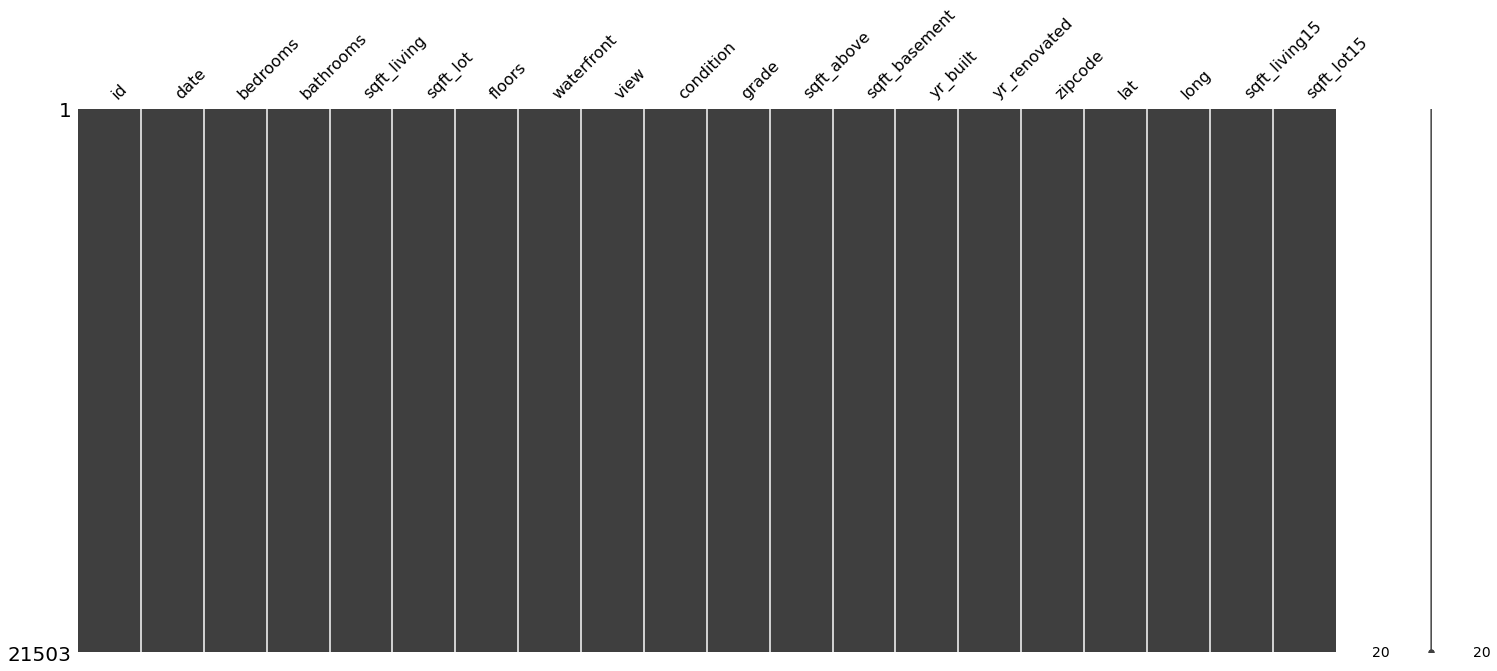

In [105]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [106]:
for c in data.columns:
    print(f'{c} : {len(data.loc[data[c].isnull(), c])}')

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [107]:
train_len

15035

In [108]:
sub_id = data['id'][train_len:]  # id 컬럼의 train_len 길이 이후, sub_id에 id 백업
del data['id']
# data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

In [109]:
sub_id # testset_id컬럼 백업

0       15035
1       15036
2       15037
3       15038
4       15039
        ...  
6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, Length: 6468, dtype: int64

In [110]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [111]:
data[data['date'] == 201420]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

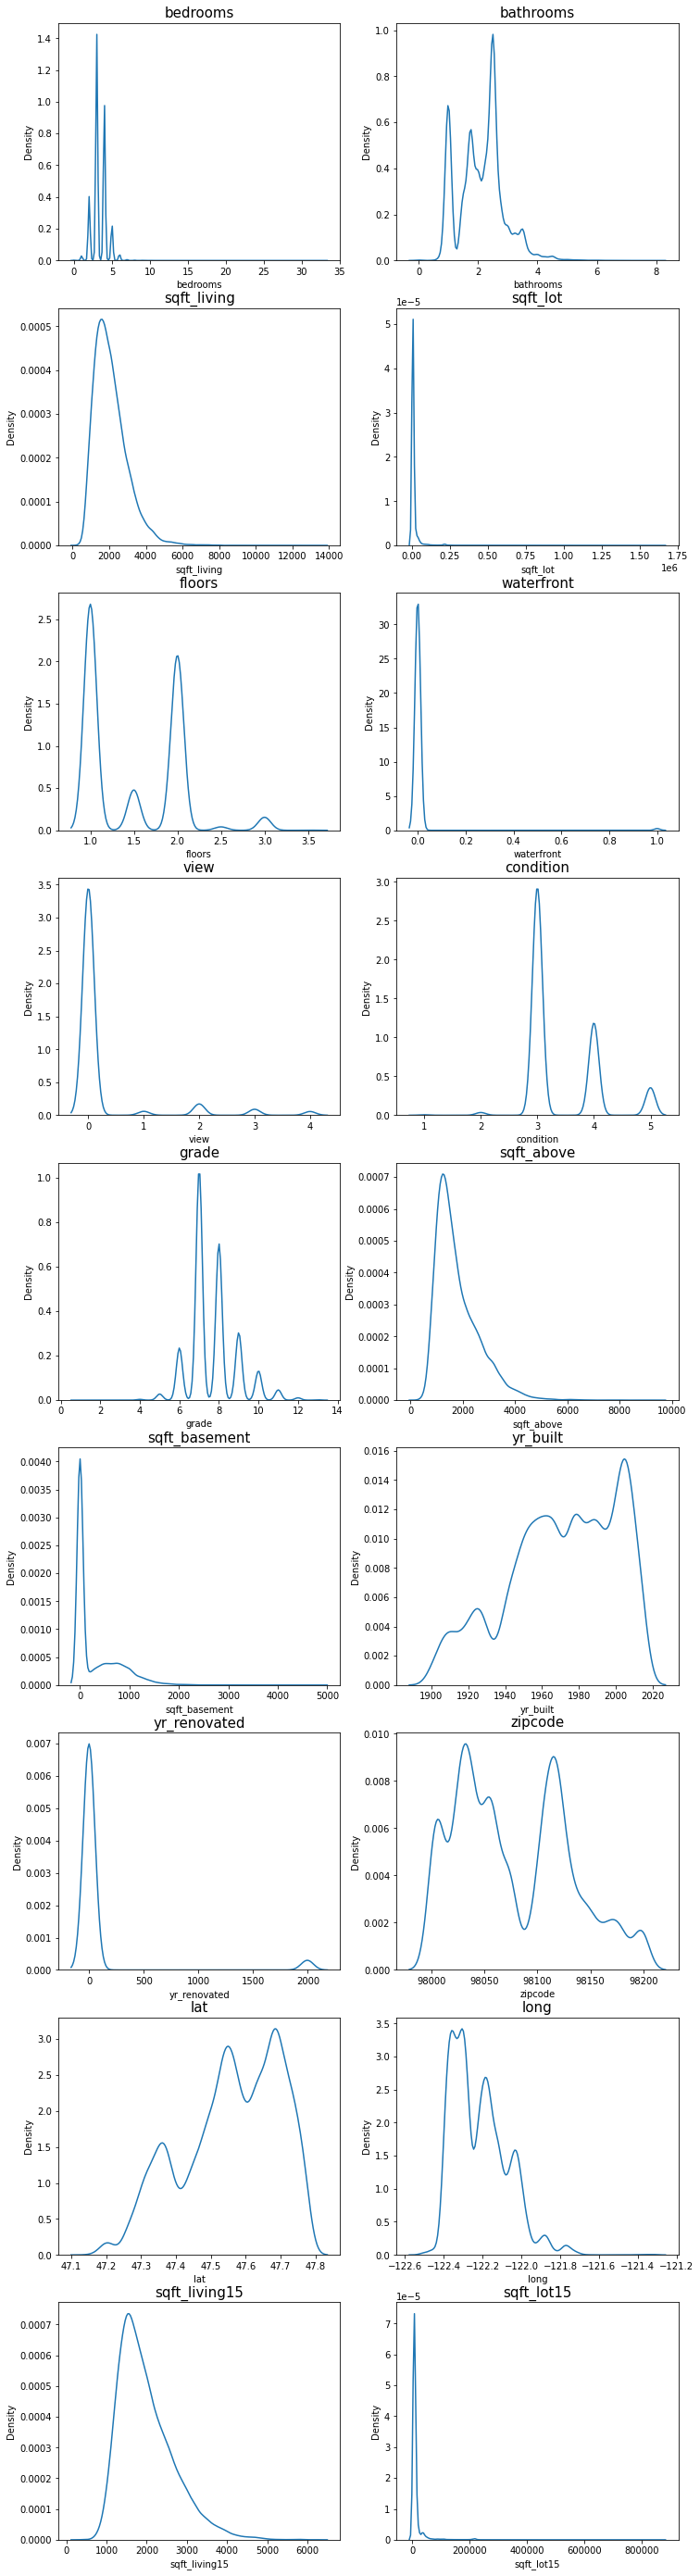

In [113]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])  # ax는 큰 도화지 안에 작은 그림들
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [120]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)  # 자연로그 대입

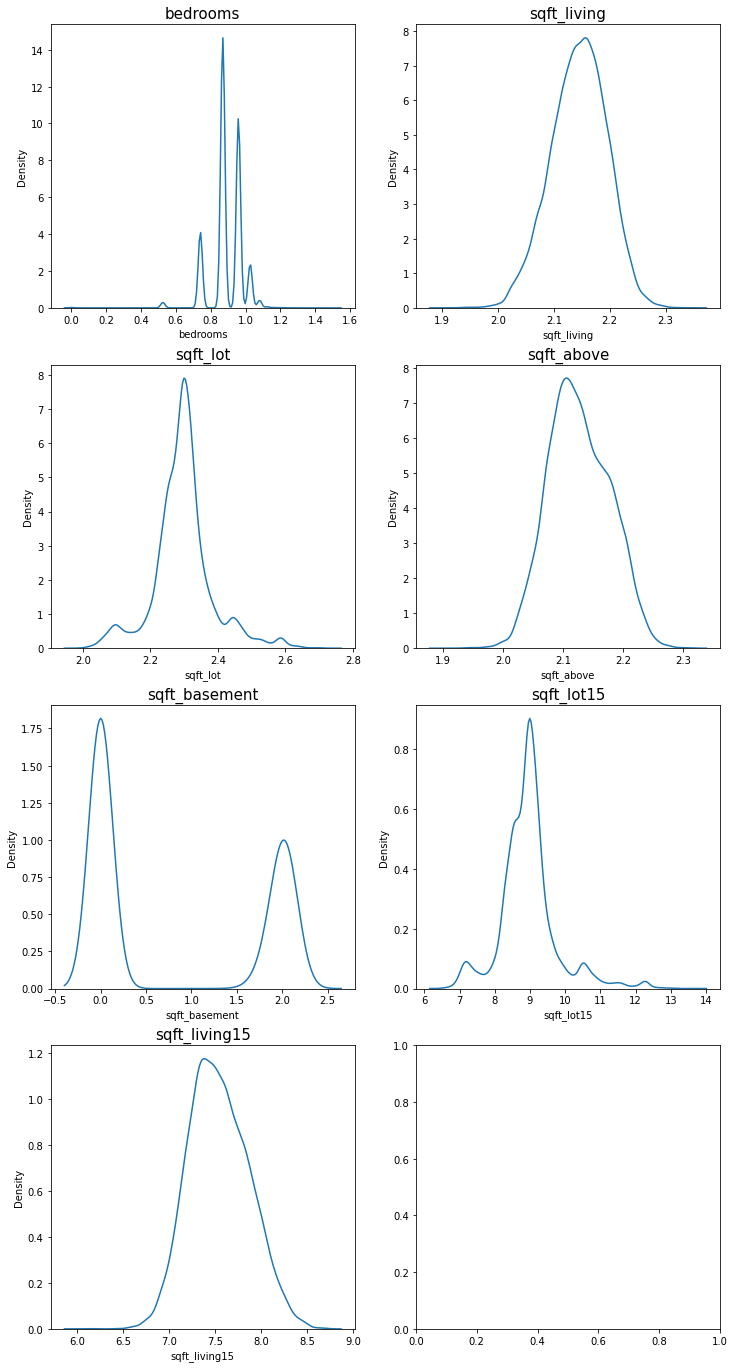

In [122]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data = data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [152]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
- 참고자료 : https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.
- 여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.
- 앙상블 학습은 하나의 강한 알고리즘보다 여러개의 약한 알고리즘의 효과가 더 좋다는 개념에서 출발한다. 

In [123]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [139]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [142]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [148]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [153]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)  # 각각의 모델을 학습하고 각각의 모델에 저장
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [154]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

### 제출 준비

__제출파일 샘플__

In [157]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


### 제출하기
- 파일 저장

In [155]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [156]:
sub.to_csv('submission.csv', index=False)

In [147]:
sub

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05
...,...,...
6463,21498,2.478657e+05
6464,21499,4.156358e+05
6465,21500,4.520817e+05
6466,21501,3.415730e+05
